In [1]:
import os
import sys
import pandas as pd
import csv
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
from xgboost import XGBRegressor,plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import Normalizer
import xgboost as xgb
from xgboost import plot_importance

In [3]:
from matplotlib import pyplot
%matplotlib inline

In [4]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
<a href="javascript:code_toggle_err()"><button>here</button></a>''')

### merging data to one data frame

In [17]:
data_folder = '../data'
data_files = os.listdir(data_folder)

In [18]:
print(data_files)

['22306_24.65_73.75_2014.csv', '22306_24.65_73.75_2000.csv', '22306_24.65_73.75_2012.csv', '22306_24.65_73.75_2013.csv', '22306_24.65_73.75_2008.csv', '22306_24.65_73.75_2005.csv', '22306_24.65_73.75_2007.csv', '22306_24.65_73.75_2006.csv', '22306_24.65_73.75_2009.csv', '22306_24.65_73.75_2001.csv', '22306_24.65_73.75_2011.csv', '22306_24.65_73.75_2004.csv', '22306_24.65_73.75_2010.csv', '22306_24.65_73.75_2003.csv', '22306_24.65_73.75_2002.csv']


In [19]:
four_year_data_files = []
for file in data_files:
    if file[-8:-4] == '2014' or file[-8:-4] == '2011' or file[-8:-4] == '2013' or file[-8:-4] == '2012':
        four_year_data_files.append(file)

In [20]:
merged_df = pd.read_csv(data_folder+'/'+four_year_data_files[0])
new_columns = merged_df.iloc[1]
year_all = merged_df[2:]
year_all.columns =new_columns
merged_df = year_all.loc[:, year_all.columns.notnull()]


for i in four_year_data_files[1:]:
    df = pd.read_csv(data_folder+'/'+i)
    new_columns = df.iloc[1]
    year_all = df[2:]
    year_all.columns =new_columns
    df = year_all.loc[:, year_all.columns.notnull()]
    
    merged_df = pd.concat([merged_df,df],ignore_index=True)
    
print(merged_df.shape)   

(35040, 21)


In [21]:
year_2014 = merged_df
year_2014.head()
year_2014.shape

(35040, 21)

In [22]:
year = merged_df.drop(columns=['Year','Month','Day','Minute','DHI','DNI','Clearsky DHI','Clearsky DNI','Fill Flag','Dew Point','Clearsky GHI','Solar Zenith Angle','Wind Direction','Snow Depth','Precipitable Water'])

In [23]:
year.to_csv('../merged_data.csv',index=False, sep=',', encoding='utf-8')
year.head()
year = year.replace('-',0).astype('float64')
year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 6 columns):
Hour                 35040 non-null float64
GHI                  35040 non-null float64
Temperature          35040 non-null float64
Pressure             35040 non-null float64
Relative Humidity    35040 non-null float64
Wind Speed           35040 non-null float64
dtypes: float64(6)
memory usage: 1.6 MB


In [24]:
year.head()

1,Hour,GHI,Temperature,Pressure,Relative Humidity,Wind Speed
0,0.0,0.0,12.751340,957.930542,58.411399,4.430836
1,1.0,0.0,12.196895,957.762268,67.295928,4.453419
2,2.0,0.0,11.806139,957.878052,72.567490,4.335502
3,3.0,0.0,11.510596,957.623596,75.299340,4.233897
4,4.0,0.0,11.306807,957.932861,76.799288,4.197238


In [25]:
X = year.drop(columns=['GHI'])
Y = year.pop('GHI')

transformer = Normalizer().fit(X)
X_norm = transformer.transform(X)


seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

## data plots
plot for data analysis

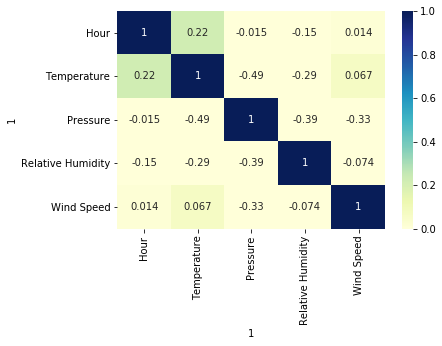

In [26]:
corr_hm = sns.heatmap(X.corr(), 
                xticklabels=X.corr().columns,
                yticklabels=X.corr().columns,vmin=0,vmax=1,cmap="YlGnBu",annot=True)
plt.show()

corr_hm.figure.savefig("../docs/corr_heatmap.png",dpi=200,bbox_inches = "tight")

### Box plots

In [ ]:
sns.boxplot(y=Y)
plt.show()

In [27]:
model = XGBRegressor(n_jobs=-1)
print(model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)


In [28]:
learning_rate = [0.1, 0.2, 0.3,0.4,0.5,0.6]
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", cv=kfold)
grid_result = grid_search.fit(X_train, y_train,verbose=True)

/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/pyth

/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated a

In [29]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -5125.152635 using {'learning_rate': 0.4}
-5383.179803 (720.479030) with: {'learning_rate': 0.1}
-5177.245445 (729.262917) with: {'learning_rate': 0.2}
-5202.966768 (674.647170) with: {'learning_rate': 0.3}
-5125.152635 (719.295536) with: {'learning_rate': 0.4}
-5140.321719 (755.874965) with: {'learning_rate': 0.5}
-5190.911439 (752.312710) with: {'learning_rate': 0.6}


In [30]:
n_estimators = [5, 10, 20 , 50, 100, 150, 200]
max_depth = [2, 4, 6, 8, 10]
learning_rate = [0.4]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate)


kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", cv=kfold,verbose=1)
grid_result = grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(da

/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated a

/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated a

/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated a

/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated a

/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated a

/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated a

/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated a

/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated a

/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated a

In [31]:
print("--------------------------------------------------------------------")
print("Best: %f using %s" % (math.sqrt(-grid_result.best_score_), grid_result.best_params_))
print("--------------------------------------------------------------------")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (math.sqrt(-mean), stdev, param))
scores = [math.sqrt(-x) for x in grid_result.cv_results_['mean_test_score']]
scores = np.array(scores).reshape(len(max_depth), len(n_estimators))
%matplotlib notebook
%matplotlib notebook
score = {}
for ind, i in enumerate(max_depth):
    score[i] = scores[ind]

--------------------------------------------------------------------
Best: 69.636483 using {'learning_rate': 0.4, 'max_depth': 8, 'n_estimators': 10}
--------------------------------------------------------------------
124.672892 (1674.391573) with: {'learning_rate': 0.4, 'max_depth': 2, 'n_estimators': 5}
93.666156 (953.706384) with: {'learning_rate': 0.4, 'max_depth': 2, 'n_estimators': 10}
83.919309 (799.385995) with: {'learning_rate': 0.4, 'max_depth': 2, 'n_estimators': 20}
78.461062 (747.339572) with: {'learning_rate': 0.4, 'max_depth': 2, 'n_estimators': 50}
75.763497 (735.151627) with: {'learning_rate': 0.4, 'max_depth': 2, 'n_estimators': 100}
74.466715 (755.319281) with: {'learning_rate': 0.4, 'max_depth': 2, 'n_estimators': 150}
73.657833 (760.074194) with: {'learning_rate': 0.4, 'max_depth': 2, 'n_estimators': 200}
86.243571 (952.594538) with: {'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 5}
74.353242 (698.923154) with: {'learning_rate': 0.4, 'max_depth': 4, 'n_est

Index(['Hour', 'Temperature', 'Pressure', 'Relative Humidity', 'Wind Speed'], dtype='object', name=1)
[0.6609801  0.3168856  0.00854238 0.00907345 0.00451849]


<IPython.core.display.Javascript object>


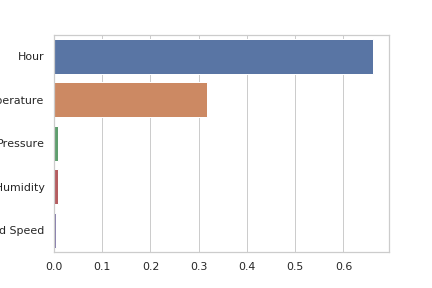

In [32]:
sns.set(style="whitegrid")
print(X.columns)
print(grid_result.best_estimator_.feature_importances_)


# sns_plot = sns.barplot(X.columns,grid_result.best_estimator_.feature_importances_)
# sns_plot.set_xticklabels(sns_plot.get_xticklabels(), rotation=30)
# fig = sns_plot.get_figure()
# fig.savefig("../docs/feature_importance_vertical.png",dpi=200,bbox_inches = "tight")

sns_plot = sns.barplot(grid_result.best_estimator_.feature_importances_, X.columns)
fig = sns_plot.get_figure()
fig.savefig("../docs/feature_importance_horizontal.png",dpi=200,bbox_inches = "tight")

In [36]:
clf = XGBRegressor(max_depth=8, learning_rate=0.4, n_estimators=10)
scores = sklearn.model_selection.cross_val_score(clf, X, Y, 
                                              cv=kfold, scoring='neg_mean_squared_error')

/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/pyth

In [37]:
print("RSME: %0.2f (+/- %0.2f) " % (math.sqrt(-scores.mean()), scores.std()))

RSME: 68.41 (+/- 675.34) 


/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


<IPython.core.display.Javascript object>


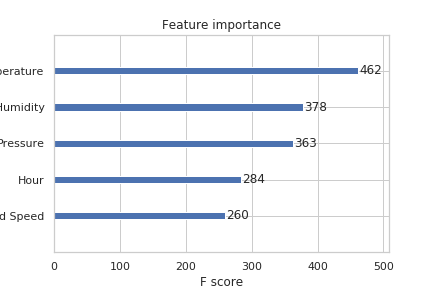

In [38]:
clf.fit(X,Y)
plot_importance(clf)
pyplot.show()

[0.67034477 0.31161952 0.00538263 0.00891425 0.00373885]


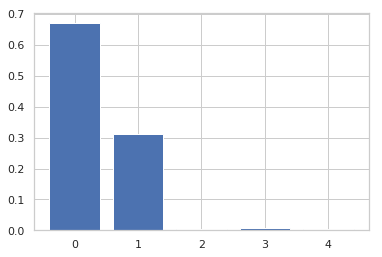

In [39]:
print(clf.feature_importances_)
%matplotlib inline
plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.show()

In [40]:
## doesn't required for cross validation

predictinos = clf.predict(X_test)
squared_sum = 0
for counter,i in enumerate(y_test):
    squared_sum += ((i)-predictinos[counter])**2
print(math.sqrt(squared_sum/len(y_test)))   

59.75833950021052


In [ ]:
import numpy as np
from bokeh.models import Label
from bokeh.layouts import gridplot
from bokeh.plotting import figure, save, output_file

p1 = figure()
p1.grid.grid_line_alpha=0.6
p1.xaxis.axis_label = 'n_estimators'
p1.yaxis.axis_label = 'RSME'

p1.line(n_estimators, score[2] , color='#A6CEE3', legend="max_depth:2")
p1.circle(n_estimators, score[2], color='#A6CEE3', legend="max_depth:2")
p1.line(n_estimators, score[4] , color='#000000', legend="max_depth:4")
p1.circle(n_estimators, score[4], color='#000000', legend="max_depth:4")
p1.line(n_estimators, score[6] , color='#FFFF00', legend="max_depth:6")
p1.circle(n_estimators, score[6], color='#FFFF00', legend="max_depth:6")
p1.line(n_estimators, score[8] , color='#00FF00', legend="max_depth:8")
p1.circle(n_estimators, score[8], color='#00FF00', legend="max_depth:8")
p1.line(n_estimators, score[10] , color='#000080', legend="max_depth:10")
p1.circle(n_estimators, score[10], color='#000080', legend="max_depth:10")

output_file("../docs/rmse_plot_for_xgboost_model.html", title="RSME Plots")

save(gridplot([[p1]], plot_width=900, plot_height=600))